## Data set preparation for ML model generation for WM apothecia prediction in irrigated environments


## Notes
* weather predictors and  principal components data don't include categorical data (soil, crop, spacing)
* look into reducing the number of categorical vars to increase number of weather vars

### Set up/check environment

In [1]:
# Check environment
!conda info
# active environment should be WM_ML


     active environment : WM_ML
    active env location : /opt/anaconda3/envs/WM_ML
            shell level : 1
       user config file : /Users/jilliancheck/.condarc
 populated config files : /Users/jilliancheck/.condarc
          conda version : 24.11.3
    conda-build version : 24.5.1
         python version : 3.12.4.final.0
                 solver : libmamba (default)
       virtual packages : __archspec=1=m1
                          __conda=24.11.3=0
                          __osx=15.0=0
                          __unix=0=0
       base environment : /opt/anaconda3  (writable)
      conda av data dir : /opt/anaconda3/etc/conda
  conda av metadata url : None
           channel URLs : https://repo.anaconda.com/pkgs/main/osx-arm64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/osx-arm64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /opt/anaconda3/pkgs
     

In [2]:
# Import packages 
import pandas as pd
import random
import numpy as np
import sklearn
from sklearn import datasets
from datetime import datetime
from itertools import cycle
import glob2
import os
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.preprocessing import LabelBinarizer as lb

# set the number of maximum displayed rows for printed dataframes to 1000
pd.set_option('display.max_rows', 1000)

### Perform correlation-based feature selection

#### For RTMA with SM and ST data

In [4]:
weather_df = pd.read_csv('/Users/jilliancheck/OneDrive - Michigan State University/Documents/Work/White mold/Modeling/jupyter notebooks/WM train test data Fall 24/RTMA_LX_23_df.csv')

In [5]:
# reduce predictor pool using point biserial and kendall correlation analyses to pick top 8 strongly and significanly correlated weather predictors
# Load your dataset into a pandas DataFrame
data = weather_df

# creating new column 'row shading' which is the product of canopy closure and row spacing

row_shading = weather_df['canopy_avg'] * weather_df['spacing (m)']
insert_index = weather_df.columns.get_loc('target') + 1  # Insert after col1
weather_df.insert(insert_index, 'row_shading', row_shading)

# Select the binary target variable and the list of continuous variables
target_variable = 'target'  # Replace 'target' with the actual column name of your target variable

# RTMA + LOCOMOS
continuous_variables = ['canopy_avg', 
                        'row_shading', 
                        'MA_MeanAT', 
                        'MA_MeanDP', 
                        'MA_MeanRH', 
                        'MA_MeanWS',
                        'MA_MeanRH86', 
                        'MA_MeanATD', 
                        'MA_MeanRF_IBM',
                        'MA_MeanSM_IR',
                        'MA_MeanST_IR',
                        'MA_MaxAT',
                        'MA_MaxDP', 
                        'MA_MaxRH', 
                        'MA_MaxWS',
                        'MA_MaxRH86',
                        'MA_MaxRF_IBM',
                        'MA_MaxSM_IR',
                        'MA_MaxST_IR',
                        'MA_MinAT', 
                        'MA_MinDP', 
                        'MA_MinRH', 
                        'MA_MinWS', 
                        'MA_MinRH86',
                        'MA_MinATD', 
                        'MA_MinSM_IR', 
                        'MA_MinST_IR', 
                        'MA_SumAT', 
                        'MA_SumDP',
                        'MA_SumRH', 
                        'MA_SumWS', 
                        'MA_SumRH86', 
                        'MA_SumATD',
                        'MA_SumRF_IBM',
                        'MA_SumSM_IR', 
                        'MA_SumST_IR']

In [6]:
# perform point biserial correlation analysis for each continuous variable
correlations = []
p_values = []
for variable in continuous_variables:
    correlation, p_value = stats.pointbiserialr(data[variable], data[target_variable])
    correlations.append(correlation)
    p_values.append(p_value)

# create a DataFrame to store and display the correlation results
correlation_results = pd.DataFrame({'Variable': continuous_variables, 'Correlation': correlations, 'P-value': p_values}).sort_values('P-value', ascending = True)

# print the correlation results
display(correlation_results)

,Variable,Correlation,P-value
1,row_shading,0.438921,2.681733e-08
0,canopy_avg,0.433042,4.297571e-08
15,MA_MaxRH86,0.404267,3.812146e-07
29,MA_SumRH,0.393383,8.264643e-07
13,MA_MaxRH,0.393202,8.370079e-07
4,MA_MeanRH,0.392203,8.973588e-07
21,MA_MinRH,0.389704,1.066930e-06
18,MA_MaxST_IR,-0.376896,2.534744e-06
28,MA_SumDP,0.376708,2.566484e-06
3,MA_MeanDP,0.376097,2.672157e-06


In [7]:
# perform kendall correlation analysis for each continuous variable
correlations = []
p_values = []
for variable in continuous_variables:
    correlation, p_value = stats.kendalltau(data[variable], data[target_variable])
    correlations.append(correlation)
    p_values.append(p_value)

# create a DataFrame to store and display the correlation results
correlation_results = pd.DataFrame({'Variable': continuous_variables, 'Correlation': correlations, 'P-value': p_values}).sort_values('P-value', ascending = True)

# print the correlation results
display(correlation_results)

,Variable,Correlation,P-value
1,row_shading,0.342796,4.292305e-07
15,MA_MaxRH86,0.354588,1.151932e-06
13,MA_MaxRH,0.310189,5.260405e-06
18,MA_MaxST_IR,-0.308423,5.524498e-06
29,MA_SumRH,0.307632,6.272566e-06
4,MA_MeanRH,0.304841,7.539870e-06
32,MA_SumATD,0.304449,8.668940e-06
7,MA_MeanATD,0.302489,9.596530e-06
21,MA_MinRH,0.298205,1.185871e-05
0,canopy_avg,0.293974,1.459521e-05


In [8]:
# index highest correlated predictors (unique functions) and most informative biological predictors
    # and add to new data frame for training and testing data set
    # Considering only one PC or RF/IR since PC also includes the irrigation data
# based on kendall correlation and point biserial correlation 
# for RTMA and ST/SM

weather_reduced_df = weather_df.loc[:,['target', 
                                       'soil type', #must remove categorical data for augmentation
                                       'row_shading',
                                       'MA_MaxRH86',
                                       'MA_SumATD',
                                       'MA_SumRF_IBM',
                                       'MA_MaxWS',
                                       'MA_MaxST_IR',
                                       'MA_SumSM_IR'
                                       ]]


In [9]:
display(weather_reduced_df)

,target,soil type,row_shading,MA_MaxRH86,MA_SumATD,MA_SumRF_IBM,MA_MaxWS,MA_MaxST_IR,MA_SumSM_IR
0,1,loam,36.81820,0.933333,568,93.8,3.942593,22.310800,3117.916742
1,0,loam,37.07660,0.966667,517,122.8,3.984259,22.664764,5779.277750
2,1,loamy sand,47.20050,0.933333,563,86.6,4.750926,23.243283,791.432858
3,1,loamy sand,47.37390,0.933333,603,77.6,4.187037,22.354040,2934.870167
4,1,loamy sand,44.98710,0.933333,542,68.5,4.448148,22.711488,4805.097617
5,0,loamy sand,31.03860,0.933333,547,60.0,4.020370,22.757464,6058.521167
6,0,loam,37.11460,0.900000,542,252.9,5.171296,22.425478,859.220905
7,1,loam,37.20580,0.900000,590,235.0,5.139815,20.494014,2830.031130
8,1,loam,37.81760,1.000000,575,210.3,5.137037,20.208235,4682.342042
9,1,loam,37.36920,1.000000,550,49.5,4.758333,20.159344,6331.651940


In [ ]:
# Diverging bar correlation plot

# Create diverging bar chart for selected variables
import pandas as pd
import matplotlib.pyplot as plt
import string as str

data = [['Row shading', 0.438921], 
        ['Max RHD', 0.404267], 
        ['Sum ATD', 0.373649], 
        ['Sum soil\nmoisture', 0.296810],
        ['Sum rainfall', 0.119867],
        ['Max WS', -0.056020], 
        ['Max soil\ntemperature', -0.376896]]


bc = pd.DataFrame(data, columns = ['Weather variable', 'Correlation value'])

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=24)

for i in range(len(bc)):
    # Colour of bar chart is set to red if the sales is < 60000 and green otherwise
    bc['colors'] = ['red' if x < 0 else 'green' for x in bc['Correlation value']]

# Sort values from lowest to highest
bc.sort_values('Correlation value', inplace=True)

# Resets initial index in Dataframe to None
bc.reset_index(inplace=True)

# Draw plot
plt.figure(figsize=(15,7.5), dpi=600)

# Plotting the horizontal lines
plt.hlines(y=bc.index, xmin=0, xmax=bc['Correlation value'],
           color=bc.colors, alpha=0.75, linewidth=10)

# Setting x axis and y axis labels
plt.gca().set(ylabel='Weather variable', xlabel='Correlation coefficients')

# Setting y axis
plt.yticks(bc.index, bc['Weather variable'])

# Title of Bar Chart
plt.title('Correlation coefficients between apothecia presence and weather variables', fontdict={'size': 24})

# Optional grid layout
plt.grid(linestyle='--', alpha=0.5)

# Save figure
#plt.savefig('Corr plot 2025', dpi = 600, format=None, bbox_inches="tight")

# Displaying the Diverging Bar Chart
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = [['Row shading', 0.438921, '***'], 
        ['Max RHD', 0.404267, '***'], 
        ['Sum ATD', 0.373649, '***'], 
        ['Sum soil\nmoisture', 0.296810, '***'],
        ['Sum rainfall', 0.119867, ''],
        ['Max WS', -0.056020, ''], 
        ['Max soil\ntemperature', -0.376896, '***']]

bc = pd.DataFrame(data, columns=['Weather variable', 'Correlation value', 'SigVal'])

plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('axes', labelsize=24)

# Assign colors based on correlation value
bc['colors'] = ['red' if x < 0 else 'green' for x in bc['Correlation value']]

# Sort values from lowest to highest
bc.sort_values('Correlation value', inplace=True)

# Reset index in DataFrame
bc.reset_index(drop=True, inplace=True)

# Draw plot
plt.figure(figsize=(15, 7.5), dpi=600)

# Plot horizontal lines
plt.hlines(y=bc.index, xmin=0, xmax=bc['Correlation value'],
           color=bc.colors, alpha=0.75, linewidth=10)

# Add annotations for significance values
for i, (corr, sig) in enumerate(zip(bc['Correlation value'], bc['SigVal'])):
    if sig:  # Only add annotation if SigVal is not empty
        x_pos = corr + 0.02 if corr >= 0 else corr - 0.02  # Shift annotation position
        ha = 'left' if corr >= 0 else 'right'  # Adjust text alignment
        plt.text(x_pos, i, sig, 
                 verticalalignment='center', 
                 horizontalalignment=ha, 
                 fontsize=18, 
                 fontweight='bold')

# Set x and y axis labels
plt.gca().set(ylabel='Weather variable', xlabel='Correlation coefficients')

# Set y axis labels
plt.yticks(bc.index, bc['Weather variable'])

# Title of the plot
plt.title('Correlation coefficients between apothecia presence and weather variables', fontdict={'size': 24})

# Grid layout
plt.grid(linestyle='--', alpha=0.5)

# Set x limits
plt.xlim(-0.5, 0.5)

plt.savefig('Corr plot 2025', dpi = 600, format=None, bbox_inches="tight")

# Display the plot
plt.show()


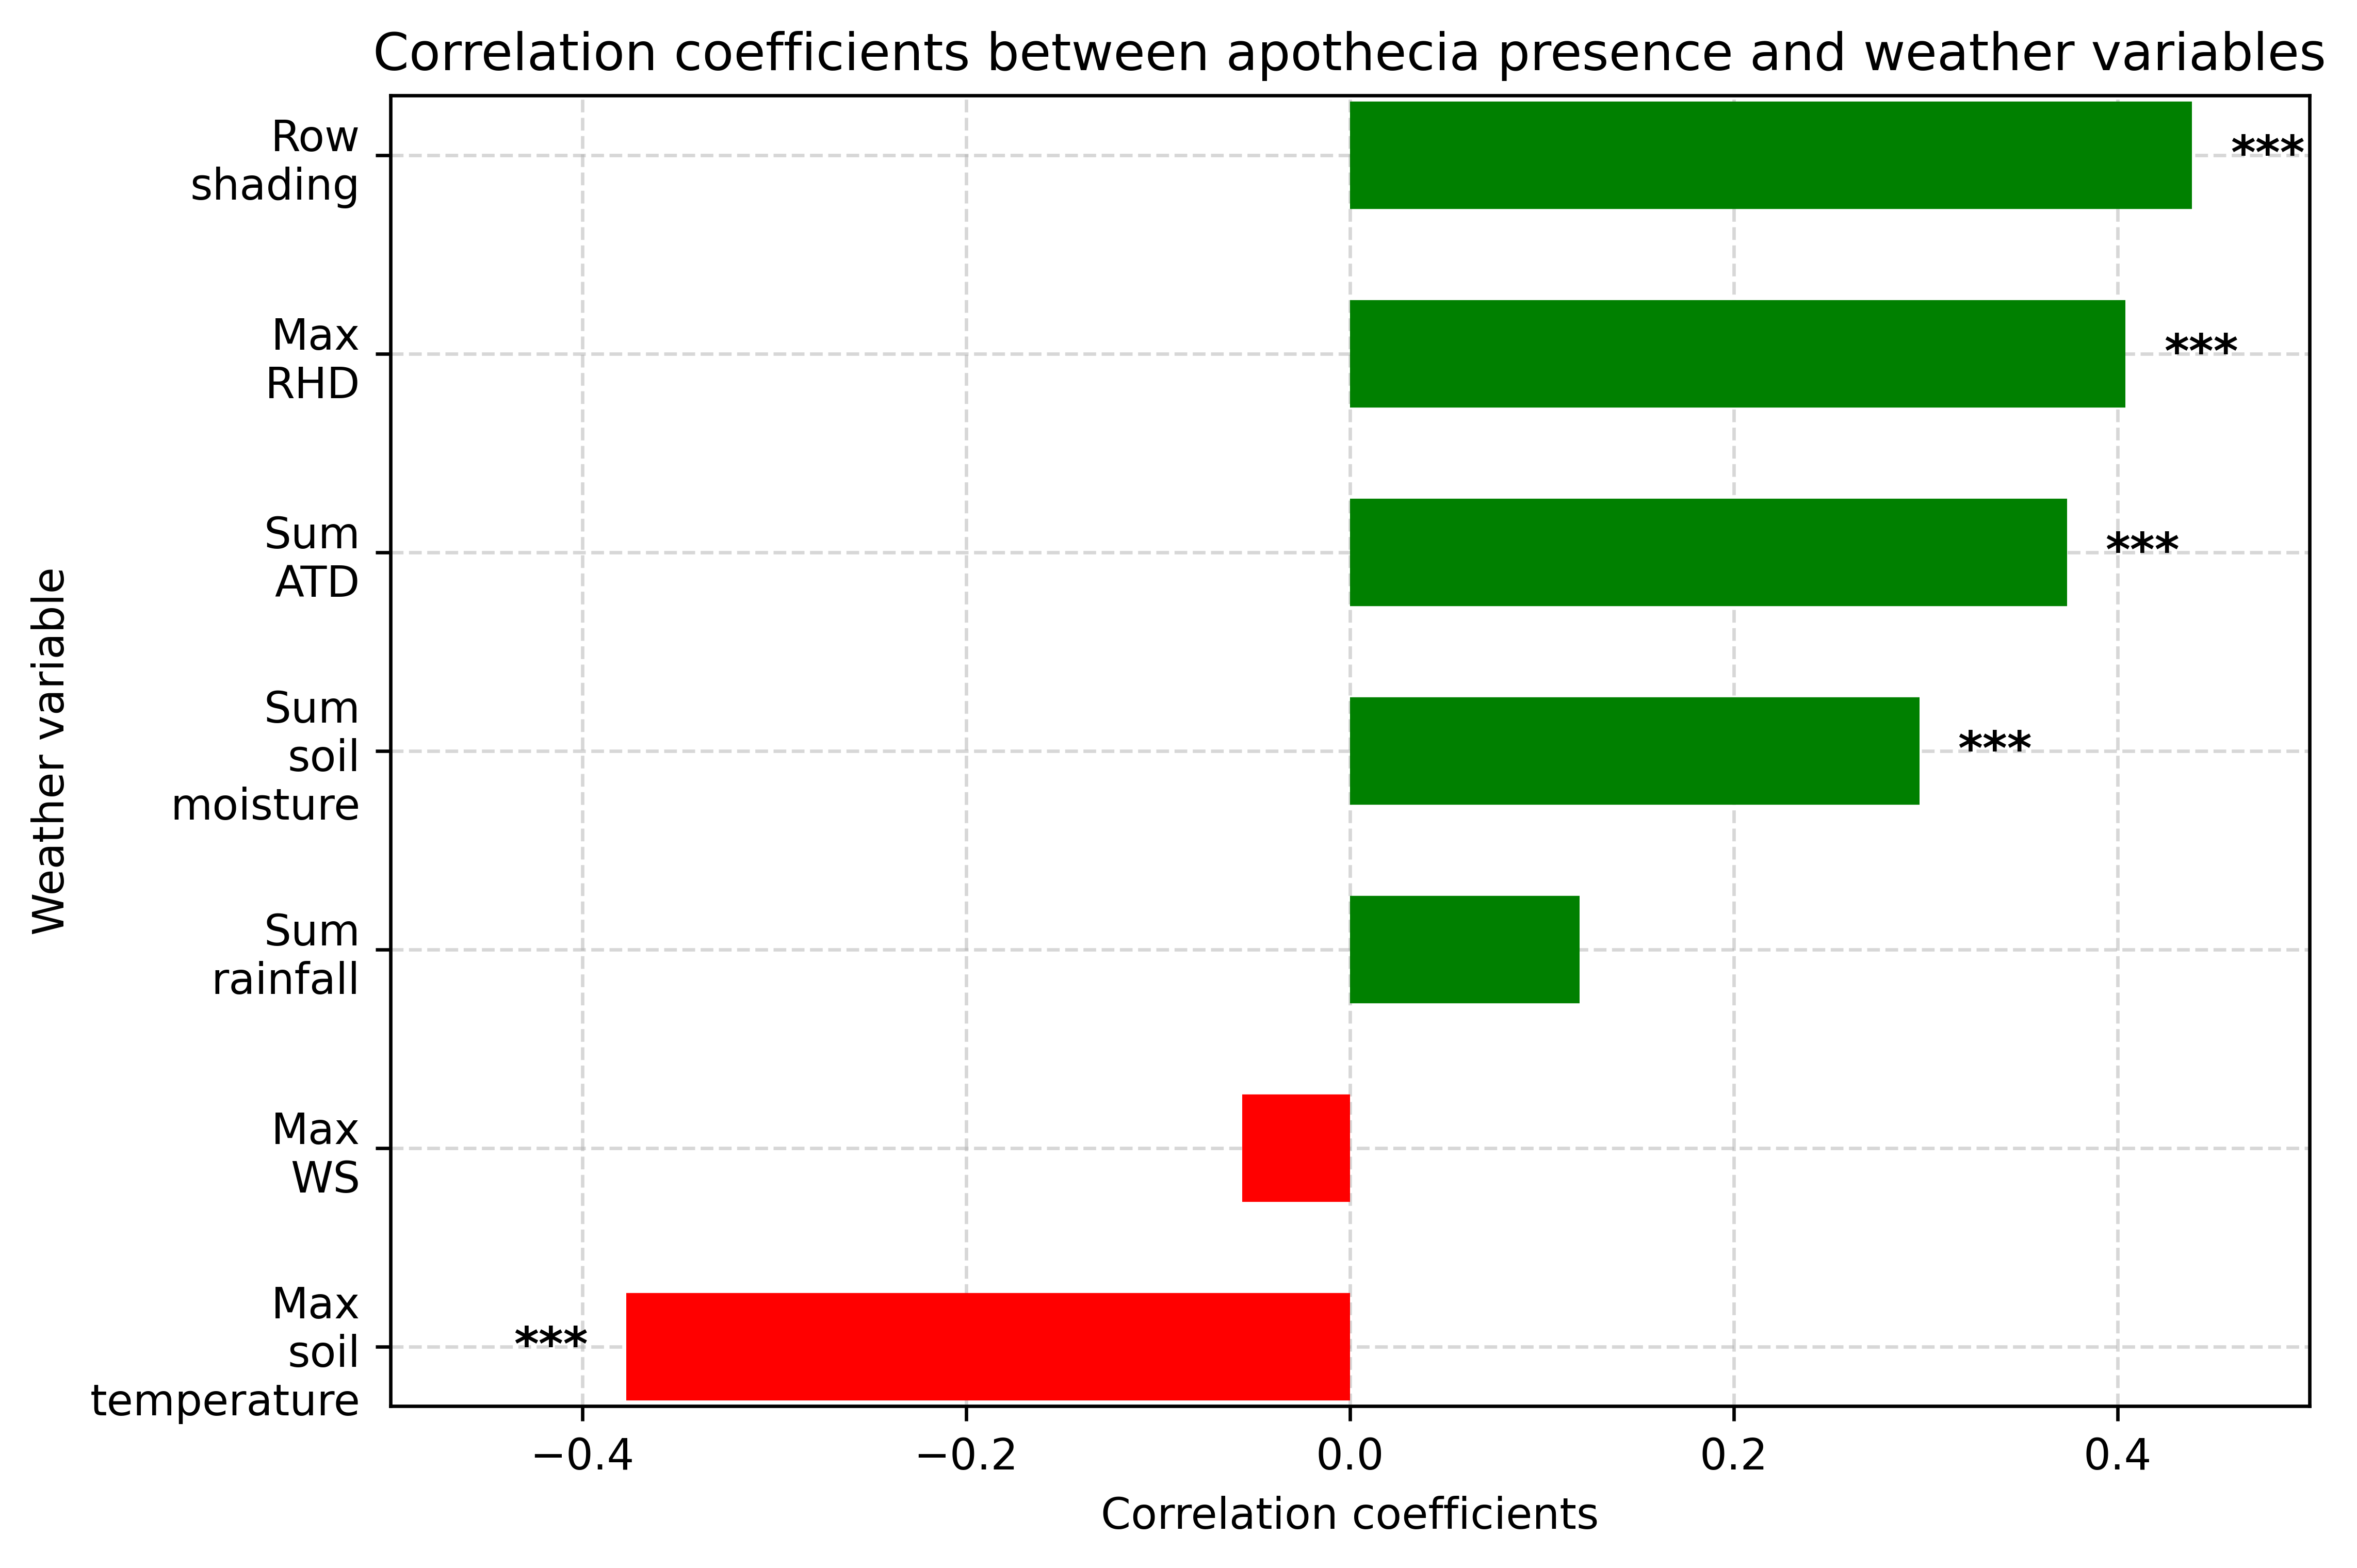

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

data = [['Row\nshading', 0.438921, '***'], 
        ['Max\nRHD', 0.404267, '***'], 
        ['Sum\nATD', 0.373649, '***'], 
        ['Sum\nsoil\nmoisture', 0.296810, '***'],
        ['Sum\nrainfall', 0.119867, ''],
        ['Max\nWS', -0.056020, ''], 
        ['Max\nsoil\ntemperature', -0.376896, '***']]

bc = pd.DataFrame(data, columns=['Weather variable', 'Correlation value', 'SigVal'])

# Assign colors based on correlation value
bc['colors'] = ['red' if x < 0 else 'green' for x in bc['Correlation value']]

# Sort values from lowest to highest
bc.sort_values('Correlation value', inplace=True)

# Reset index in DataFrame
bc.reset_index(drop=True, inplace=True)

# Draw plot
plt.figure(figsize=(8, 5.5), dpi=600)

# Plot horizontal lines
plt.hlines(y=bc.index, xmin=0, xmax=bc['Correlation value'], color=bc.colors, linewidth=25)

# Add annotations for significance values
for i, (corr, sig) in enumerate(zip(bc['Correlation value'], bc['SigVal'])):
    if sig:  # Only add annotation if SigVal is not empty
        x_pos = corr + 0.02 if corr >= 0 else corr - 0.02  # Shift annotation position
        ha = 'left' if corr >= 0 else 'right'  # Adjust text alignment
        plt.text(x_pos, i, sig, 
                 verticalalignment='center', 
                 horizontalalignment=ha,
                 fontsize=11, 
                 fontweight='bold')

# Set x and y axis labels
plt.gca().set(ylabel='Weather variable', xlabel='Correlation coefficients')

# Set y axis labels
plt.yticks(bc.index, bc['Weather variable'])

# Title of the plot
plt.title('Correlation coefficients between apothecia presence and weather variables')

# Grid layout
plt.grid(linestyle='--', alpha=0.5)

# Set x limits
plt.xlim(-0.5, 0.5)

plt.savefig('Corr plot 2025', dpi = 600, format=None, bbox_inches="tight")

# Display the plot
plt.show()


In [ ]:
# Perform max absolute rescaling to normalize predictor variables due to major scale differences
# Copy the data - only the numerical data, not including spacing since it is truly categorical
dt_max_scaled = weather_reduced_df.iloc[:, 2:]
    # Change this back to 2: if using soil type!
display(dt_max_scaled.head())

### Normalize weather-only data set

In [ ]:
# Apply normalization techniques
for column in dt_max_scaled.columns:
    dt_max_scaled[column] = dt_max_scaled[column]  / dt_max_scaled[column].abs().max()


# View normalized data
display(dt_max_scaled.head())

# Plot normalized data
sns.set_theme()
sns.set(font_scale=0.5) 
ax = sns.catplot(data=dt_max_scaled, kind = 'bar')
ax.set_xticklabels(rotation=90, ha="right")
ax.set(title = 'Max absolute rescaled data')

In [ ]:
# Split into x and y
xdat = dt_max_scaled.loc[:,dt_max_scaled.columns != 'target' ]
display(xdat.head())
ydat = pd.DataFrame(weather_df.loc[:, 'target'])
display(ydat.head())

### Weather data load out 

### Data splitting
* Training: 80%, testing 20%  
* Stratification by apothecia threshold binary

In [ ]:
# Returning the categorical soil type variable back to the data frame before stratification and load out
xdat = pd.merge(weather_reduced_df.iloc[:, 1], xdat, left_index = True, right_index = True) 
    # Change the indexing if using soil type!!!
display(xdat)

In [ ]:
# Using binary encoding to transform categorical soil type (ML cannot handle categorical)
xdat['soil type'].replace(['sand', 'loamy sand', 'loam'], [0, 1, 2], inplace=True)
display(xdat)

In [ ]:
# stratifying by ydat
x_train, x_test, y_train, y_test = train_test_split(xdat, ydat, test_size=0.20, random_state=42, stratify=ydat)

In [ ]:
# Check training and testing data sets

display(x_train)
display(y_train)
display(x_test)
display(y_test)

In [ ]:
# Checking that indexes for data split between x and y match for training and test
print('x training indexes:', x_train.index)
print('y training indexes:', y_train.index)

print('x testing indexes:', x_test.index)
print('y testing indexes:', y_test.index)

In [ ]:
# Checking stratification (equal proportions of positive solutions (target = 1) between train and test)
print(sum(y_train['target'])/len(y_train))
print(sum(y_test['target'])/len(y_test))

### Weather only - data load out

In [ ]:
x_train.to_csv(r'/Users/jilliancheck/Library/CloudStorage/OneDrive-MichiganStateUniversity/Documents/Work/White mold/Modeling/jupyter notebooks/!Finalizing - 2024/Stratified data sets/x_train_LX_corr.csv', index=False, header=True)
y_train.to_csv(r'/Users/jilliancheck/Library/CloudStorage/OneDrive-MichiganStateUniversity/Documents/Work/White mold/Modeling/jupyter notebooks/!Finalizing - 2024/Stratified data sets/y_train_LX_corr.csv', index=False, header=True)
x_test.to_csv(r'/Users/jilliancheck/Library/CloudStorage/OneDrive-MichiganStateUniversity/Documents/Work/White mold/Modeling/jupyter notebooks/!Finalizing - 2024/Stratified data sets/x_test_LX_corr.csv', index=False, header=True)
y_test.to_csv(r'/Users/jilliancheck/Library/CloudStorage/OneDrive-MichiganStateUniversity/Documents/Work/White mold/Modeling/jupyter notebooks/!Finalizing - 2024/Stratified data sets/y_test_LX_corr.csv', index=False, header=True)